In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from torch import nn, optim, Tensor
from torch.utils.data import DataLoader, TensorDataset
from torchsummary import summary

### 1. Target Function and Data Generation
Consider some target function $f:\mathbb{R}\to\mathbb{R}$, and a compact domain $D\subset \mathbb{R}$. Let $p_x$ be the uniform distribution over $D$. We then generate data $(x,y)$ such that $x\sim p_x$ and $y=f(x)$.

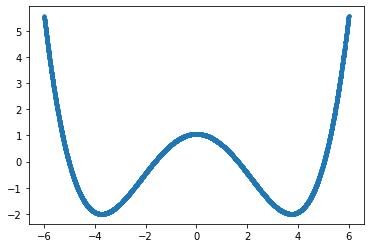

In [22]:
# DATA GENERATION

# hyperparameters
np.random.seed(0)
N = 10**4
low = -6
high = 6
params = [0.5, 0, -3.5, -0.5, 1, -3]

# define target function
def quadratic(x, _params):
    [a, b, c] = _params
    return (a*x+b)**2 + c

def target(x):
    [a1, b1, c1, a2, b2, c2] = params
    h = quadratic(x, [a1,b1,c1])
    return quadratic( h, [a2,b2,c2] ) + h

# training data
X = np.random.uniform(low, high, N)
Y = np.vectorize(target)(X)

# transform to tensor and reshape
X_tensor = torch.reshape(Tensor(X),(N,1))
y_tensor = torch.reshape(Tensor(Y),(N,1))

# visualize
plt.scatter(X, Y, marker=".")
plt.show()

Some graphical intuitions for hyperparameters:
https://www.desmos.com/calculator/pc0szofbfh.

### 1.5. Training, testing & model selection

In [3]:
# TRAINING
def train_model(model, epochs=50, batch_size=64, 
                loss_fn=nn.MSELoss(), optim=optim.Adam, optim_params=None, verbose=False):
    # load data
    dataset = TensorDataset(X_tensor, y_tensor)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # optimizer
    if optim_params != None:
        optimizer = optim(model.parameters(), **optim_params)
    else:
        optimizer = optim(model.parameters())
    
    # train
    for t in range(epochs):
        for (i, (X_batch, y_batch)) in enumerate(data_loader):
            # forward
            pred = model(X_batch.float())
            loss = loss_fn(pred, y_batch)

            # backward
            optimizer.zero_grad()  # clear gradient
            loss.backward()
            optimizer.step()

        if verbose and t%10 == 0:
            print(f"\nEpoch: {t+1:n}")
            print(f"loss={loss:.3f}")
            print("_"*50)

In [4]:
# TEST MODEL
def test_model(model, ax=None, verbose=True):
    if verbose:
        params = [p.item() for p in model.parameters()]
        print(params)

    y_pred = model(X_tensor).detach().numpy()  # shape (N,1)
    total = np.concatenate((X[:,None],Y[:,None],y_pred), axis=1)  # broadcast X,Y to (N,1)
    total = total[total[:,0].argsort()]

    ax = ax or plt.gca()
    
    ax.plot(total[:,0], total[:,2], color="red", label="prediction", linewidth=3, alpha=0.7)
    ax.plot(total[:,0], total[:,1], color="blue", label="true label", linewidth=3, alpha=0.7)
#     plt.scatter(X, y_pred, color="red", label="prediction", s=2, alpha=0.5)
#     plt.scatter(X, Y, color="blue", label="true label", s=2, alpha=1)
    plt.legend()
    if verbose:
        plt.show()

In [38]:
def grid_search_lr(module, model_params=None):
    models = []
    lr_grid = [10**(-i) for i in [1,2,3,4]]
    
    ax = None
    plt.figure(figsize=(12,10))
    
    for i, lr in enumerate(lr_grid):
        ax = plt.subplot(2, 2, i+1, sharey=ax)
        ax.set_title(f'learning rate = {lr}')
        
        if model_params == None:
            model = module()
        else:
            model = module(**model_params)
        models.append(model)
        
        train_model(model, optim_params={'lr': lr})
        test_model(model, ax=ax, verbose=False)
    plt.show()
    
    return models

### 2. Freeze-and-train Model (linear + quadratic + linear per layer)

In [6]:
# nn.Sequential wrapper
class Lambda(nn.Module):
    """
    Input: A Function
    Returns : A Module that can be used inside nn.Sequential
    """
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): 
        return self.func(x)

In [7]:
# FIRST LAYER STRUCTURE
def quad_activation(x):
    return x**2

# first_layer
class first_layer_model(nn.Module):
    def __init__(self):
        super().__init__()
        self.sequential = nn.Sequential(
            nn.Linear(1, 1),  # x -> ax+b
            Lambda(quad_activation),  # (ax+b)^2
            nn.Linear(1, 1),  # k(ax+b)^2+c
        )
        for p in self.parameters():
            p.requires_grad = True  # re-activate (in case passed to layer 2)
        
    def forward(self, x):
        return self.sequential(x)

In [8]:
# TRAIN FIRST LAYER
first_layer = first_layer_model()
summary(first_layer, (10000, 1))

train_model(first_layer, optim_params={'lr': 1e-3})

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 10000, 1]               2
            Lambda-2             [-1, 10000, 1]               0
            Linear-3             [-1, 10000, 1]               2
Total params: 4
Trainable params: 4
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.23
Params size (MB): 0.00
Estimated Total Size (MB): 0.27
----------------------------------------------------------------


[0.3968278467655182, -0.029217811301350594, 0.2874477207660675, -0.6674476265907288]


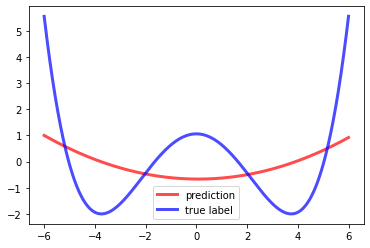

In [9]:
# FIRST LAYLER RESULT
test_model(first_layer)

In [10]:
# SECOND LAYER MODEL
# set requires_grad = False to freeze previous layer
class second_layer_model(nn.Module):
    def __init__(self, prev_layer):
        super().__init__()
        self.prev_layer = prev_layer
        for p in self.prev_layer.parameters():
            p.requires_grad = False
        
        self.sequential = nn.Sequential(
            Lambda(self.prev_layer),  # predict a first layer using already trained first-layer model
            nn.Linear(1, 1),  # x -> ax+b
            Lambda(quad_activation),  # (ax+b)^2
            nn.Linear(1, 1),  # k(ax+b)^2+c
        )
    
    def forward(self, x):
        return self.sequential(x) + self.prev_layer(x)

In [11]:
second_layer = second_layer_model(first_layer)
summary(second_layer, (N,1))

train_model(second_layer)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 10000, 1]               2
            Linear-2             [-1, 10000, 1]               2
            Lambda-3             [-1, 10000, 1]               0
            Lambda-4             [-1, 10000, 1]               0
            Linear-5             [-1, 10000, 1]               2
            Linear-6             [-1, 10000, 1]               2
 first_layer_model-7             [-1, 10000, 1]               0
 first_layer_model-8             [-1, 10000, 1]               0
            Lambda-9             [-1, 10000, 1]               0
           Linear-10             [-1, 10000, 1]               2
           Lambda-11             [-1, 10000, 1]               0
           Linear-12             [-1, 10000, 1]               2
           Linear-13             [-1, 10000, 1]               2
           Linear-14             [-1, 1

[0.3968278467655182, -0.029217811301350594, 0.2874477207660675, -0.6674476265907288, -2.294449806213379, 0.07898671180009842, 1.422391414642334, -1.9742344617843628]


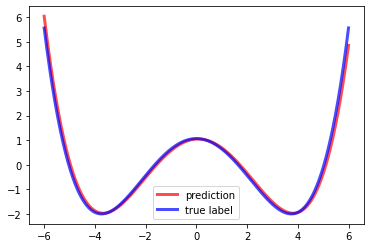

In [12]:
test_model(second_layer)

### 3. Comparison test: complete 2-layer NN
To serve as a comparison, compare the previous freeze-and-train method with the following standard structure:

*To implement correctly a skip connection, refer to [implementation](https://github.com/pytorch/vision/blob/a9a8220e0bcb4ce66a733f8c03a1c2f6c68d22cb/torchvision/models/resnet.py#L56-L72)*

In [36]:
# COMPLETE 2 LAYER NETWORK
class complete_network_model(nn.Module):
    def __init__(self, skip=None):
        super().__init__()
#         self.sequential = nn.Sequential(
#             nn.Linear(1, 1),  # x -> ax+b
#             Lambda(quad_activation),  # (ax+b)^2
#             nn.Linear(1, 1),  # k(ax+b)^2+c
#             Lambda(quad_activation),
#             nn.Linear(1, 1),
#         )
        self.skip = skip
        self.linear1 = nn.Linear(1, 1)
        self.linear2 = nn.Linear(1, 1)
        self.linear3 = nn.Linear(1, 1)
        self.actv = Lambda(quad_activation)
    
    def forward(self, x):
        identity = x
        first = self.linear1(x)
        out = self.actv(first)
        out = self.linear2(out)
        out = self.actv(out)
        out = self.linear3(out)
#         out += identity
        if self.skip == "input":
            out += identity
        elif self.skip == "first":
            out += first
        
        return out

In [37]:
complete_network = complete_network_model()
summary(complete_network, (N,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1             [-1, 10000, 1]               2
            Lambda-2             [-1, 10000, 1]               0
            Linear-3             [-1, 10000, 1]               2
            Lambda-4             [-1, 10000, 1]               0
            Linear-5             [-1, 10000, 1]               2
Total params: 6
Trainable params: 6
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.04
Forward/backward pass size (MB): 0.38
Params size (MB): 0.00
Estimated Total Size (MB): 0.42
----------------------------------------------------------------


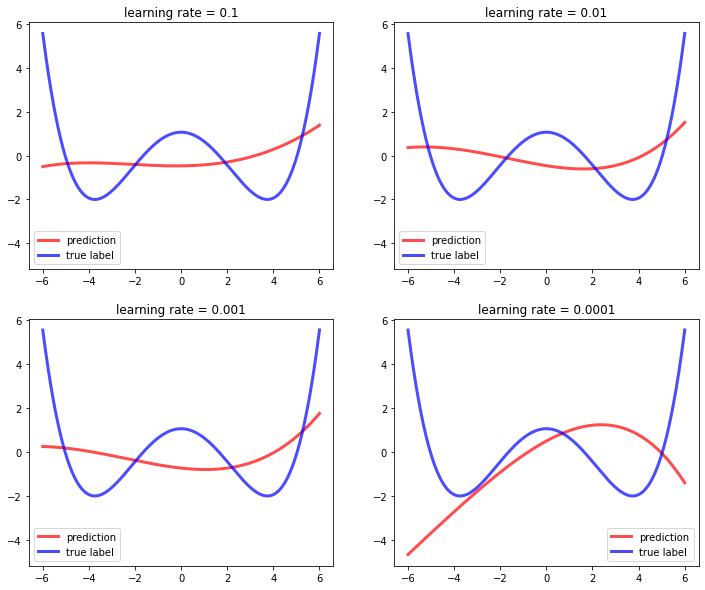

In [39]:
# skip connect with input layer
models1 = grid_search_lr(complete_network_model, {'skip': 'input'})

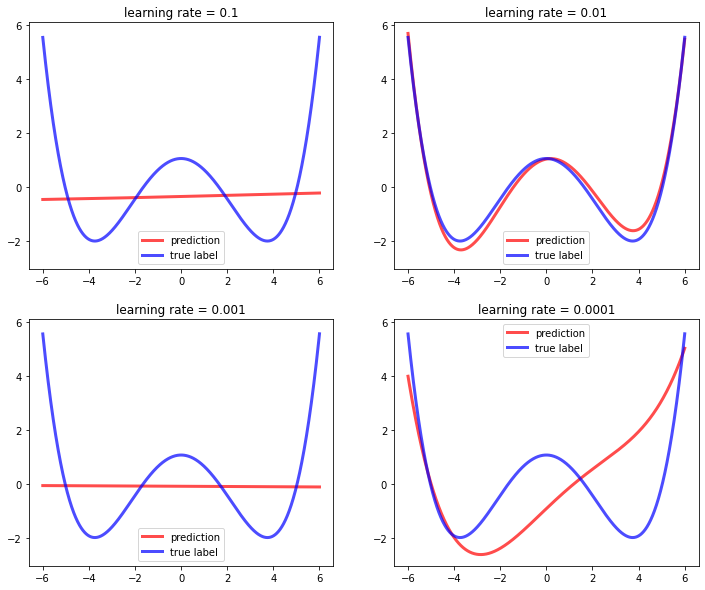

In [40]:
# skip connect with first layer
models1 = grid_search_lr(complete_network_model, {'skip': 'first'})

Optimal learning rate: for skip connection with first layer, seems that lr=0.01 is a good choice

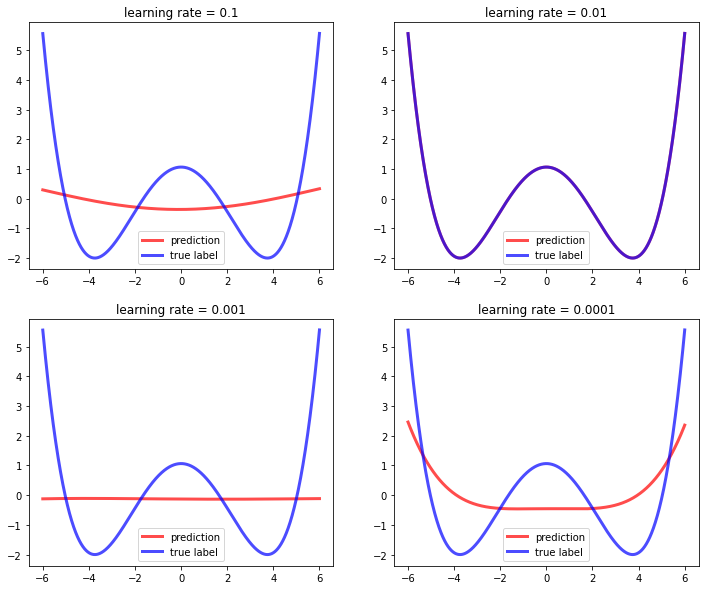

In [42]:
# no skip connection
models3 = grid_search_lr(complete_network_model, {'skip': None})

#### Caveat:
The test result is somehow sensitive to initialization... I tried several standard initializatons, but all of them don't seem good...

This becomes a big issue because I don't know whether a poor fit is due to poor initialization or it is an actual counter exmample.

### 4. Freeze-and-train with linear+quadratic per layer
In order to fit a general quadratic (of form $ax^2+b$), each "layer" is actually a linear layer + quadratic activation + another linear layer (to add the constant term). Below is an attempt to see what if we only have a linear layer with a quadratic activation. Now a perfect fit is not guaranteed.

In [16]:
# def black_box(model):
#     _optim = optim.Adam(model.parameters())
    
#     train_model(model, X, Y, epochs, batch_size, loss_fn, _optim)
#     test_model(model)

In [17]:
# class first_layer_partial(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.sequential = nn.Sequential(
#             nn.Linear(1, 1),  # x -> ax+b
#             Lambda(quad_activation),  # (ax+b)^2
#         )
    
#     def forward(self, x):
#         return self.sequential(x)

# partial_1 = first_layer_partial()
# black_box(partial_1)

In [18]:
# class second_layer_partial(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.sequential = nn.Sequential(
#             Lambda(partial_1), 
#             nn.Linear(1, 1), 
#             Lambda(quad_activation),
#         )
    
#     def forward(self, x):
#         return self.sequential(x) + partial_1(x)

# partial_2 = second_layer_partial()
# black_box(partial_2)

In [19]:
# class complete_model_partial(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.sequential = nn.Sequential(
#             nn.Linear(1, 1), 
#             Lambda(quad_activation),
#             nn.Linear(1, 1),
#             Lambda(quad_activation),
#             nn.Linear(1, 1)
#         )
    
#     def forward(self, x):
#         skip = self.sequential(x) + nn.Sequential(nn.Linear(1,1))(x)
#         normal = self.sequential(x)
#         return skip

# partial_3 = complete_model_partial()
# black_box(partial_3)

### 5. Unequal Bumps
Now we want to test another target function, which is still of W-shape, but has unequal minimums.
[Reference](https://www.desmos.com/calculator/ouqmttfdlh)

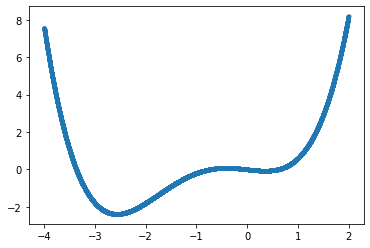

In [43]:
# training data
def target(x):
    a,b,c,d = [0.2,0.7,0,-0.3]
    return a*x**4 + b*x**3 + c*x**2 + d*x

X = np.random.uniform(-4, 2, N)
Y = np.vectorize(target)(X)

# transform to tensor and reshape
X_tensor = torch.reshape(Tensor(X),(N,1))
y_tensor = torch.reshape(Tensor(Y),(N,1))

# visualize
plt.scatter(X, Y, marker=".")
plt.show()

#### 5.1. Layer 1

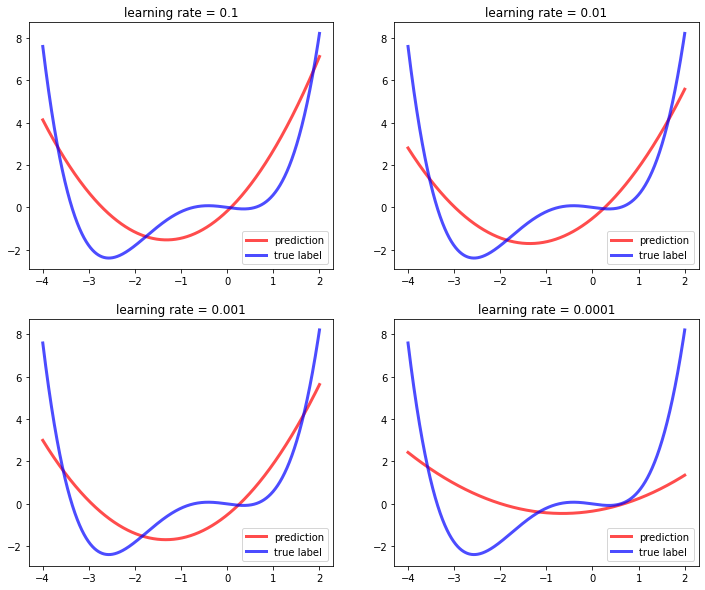

In [48]:
# train first layer
new_first_layer_models = grid_search_lr(first_layer_model)

For layer 1, it seems that lr from 0.1-0.001 are all reasonable. 

#### 5.2. Layer 2

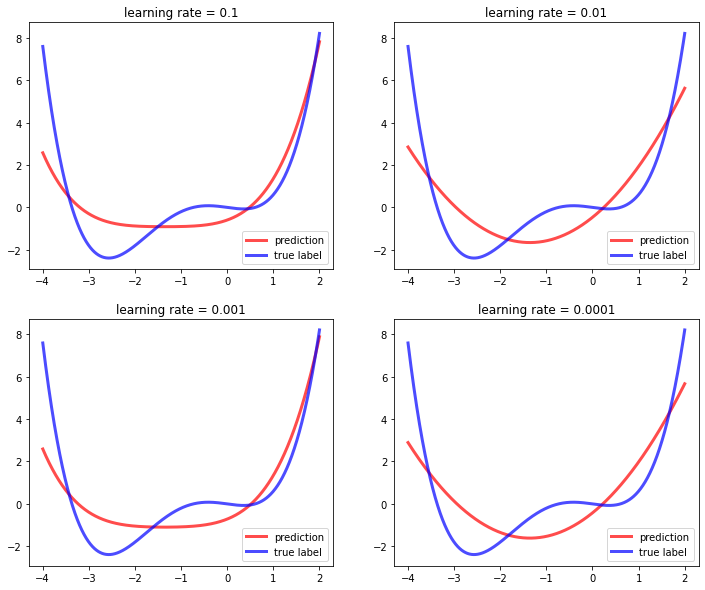

In [49]:
# trains second layer
new_second_layer_models = grid_search_lr(second_layer_model, 
                                         model_params={'prev_layer': new_first_layer_models[1]})

I think this is a reasonable evidence to say that the greedy algorithm "fails" on this specific target function with unequal bumps.

#### 5.3. Compare to normal NN

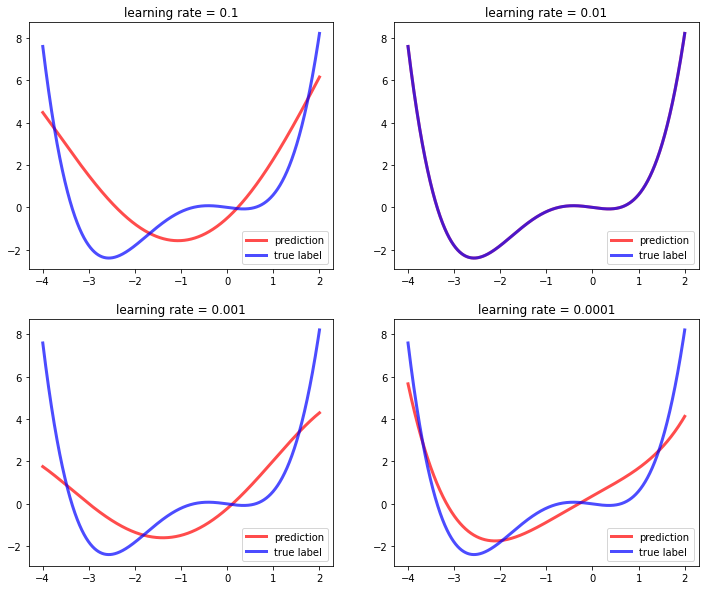

In [51]:
# compare to complete network
# with skip connection to first layer
models = grid_search_lr(complete_network_model, model_params={'skip': 'first'})

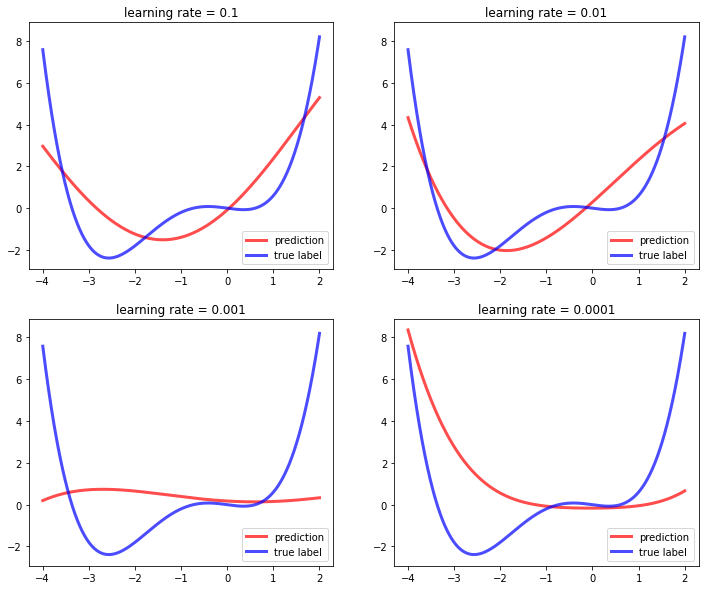

In [52]:
# without skip connection
models = grid_search_lr(complete_network_model, model_params={'skip': None})